In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Gene Nodes

Putting together the Information for the nodes and save them as a csv file.

Nodes are genes with the following information:
- Gene ID
- Gene Name
- TPM value for lung cancer
- TPM value for healthy lung tissue
- TMP difference between cancer and healthy tissue

In [10]:
df_gtex = pd.read_csv('../processed_data/GTEX_healthy_mean.csv')
df_cmp = pd.read_csv('../processed_data/CMP_cancer_mean.csv')

df_protein_gene = pd.read_csv('../import_data/ENSEMBLE/biomart_gene_protein.txt',  sep='\t')

In [11]:
# rename columns
df_gtex.rename(columns={'tpm': 'healthy tpm'}, inplace=True)
df_cmp.rename(columns={'name': 'name', 'tpm': 'cancerous tpm'}, inplace=True)

## List of genes that have a gene-protein connection

In [12]:
df_protein_gene = df_protein_gene[df_protein_gene['Protein stable ID'].notna()]
protein_genes = df_protein_gene['Gene stable ID'].unique()

len(protein_genes)

23837

## Merge CMP (cancer) and GTEx (healthy) dataset

In [13]:
df_nodes_cancer = df_cmp.copy()
df_nodes_healthy = df_gtex.copy()

df_nodes_genes = df_nodes_cancer.merge(df_nodes_healthy, on='id', how='inner')

# filter out those without gene-protein connection
df_nodes_genes = df_nodes_genes[df_nodes_genes['id'].isin(protein_genes)]

print(f"There are {df_nodes_genes.shape[0]} rows in the merged dataset. All have a healthy and a cancer TPM value.")

df_nodes_genes

There are 17626 rows in the merged dataset. All have a healthy and a cancer TPM value.


,name,cancerous tpm,id,healthy tpm
0,A1BG,0.827192,ENSG00000121410,9.456192
2,A1CF,1.355369,ENSG00000148584,0.832690
3,A2M,1.669212,ENSG00000175899,473.357464
5,A2ML1,0.952118,ENSG00000166535,33.300911
8,A3GALT2,0.643498,ENSG00000184389,0.258739
...,...,...,...,...
32858,ZXDC,20.587635,ENSG00000070476,16.684126
32859,ZYG11A,9.257833,ENSG00000203995,0.514193
32861,ZYG11B,21.124039,ENSG00000162378,13.677842
32863,ZZEF1,17.697980,ENSG00000074755,18.714613


## Normalize TPM Values
TPM values are normalized to a range between 0 and 1 to make them easier comparable.

In [14]:
# logarithmic scaling with normalization [0, 1]
def log_norm_scaling(column, min_tpm, max_tpm):
    column_log = np.log1p(column)
    
    min_log = np.log1p(min_tpm)
    max_log = np.log1p(max_tpm)
    
    column = (column_log - min_log) / (max_log - min_log)
    return column

In [15]:
# Min
print(f"Min healthy TPM:\t{df_nodes_genes['healthy tpm'].min().round(3)}")
print(f"Min cancerous TPM:\t{df_nodes_genes['cancerous tpm'].min().round(3)}\n")

# Max
print(f"Max healthy TPM:\t{df_nodes_genes['healthy tpm'].max().round(3)}")
print(f"Max cancerous TPM:\t{df_nodes_genes['cancerous tpm'].max().round(3)}")

Min healthy TPM:	0.0
Min cancerous TPM:	0.0

Max healthy TPM:	36200.774
Max cancerous TPM:	41173.932


In [16]:
# min and max over two datasets
min_tpm = min(df_nodes_genes['healthy tpm'].min(), 
              df_nodes_genes['cancerous tpm'].min()
              )
max_tpm = max(df_nodes_genes['healthy tpm'].max(), 
              df_nodes_genes['cancerous tpm'].max()
              ) 

# perform log normalization
df_nodes_genes['norm healthy tpm'] = log_norm_scaling(df_nodes_genes['healthy tpm'], min_tpm, max_tpm)
df_nodes_genes['norm cancerous tpm'] = log_norm_scaling(df_nodes_genes['cancerous tpm'], min_tpm, max_tpm)

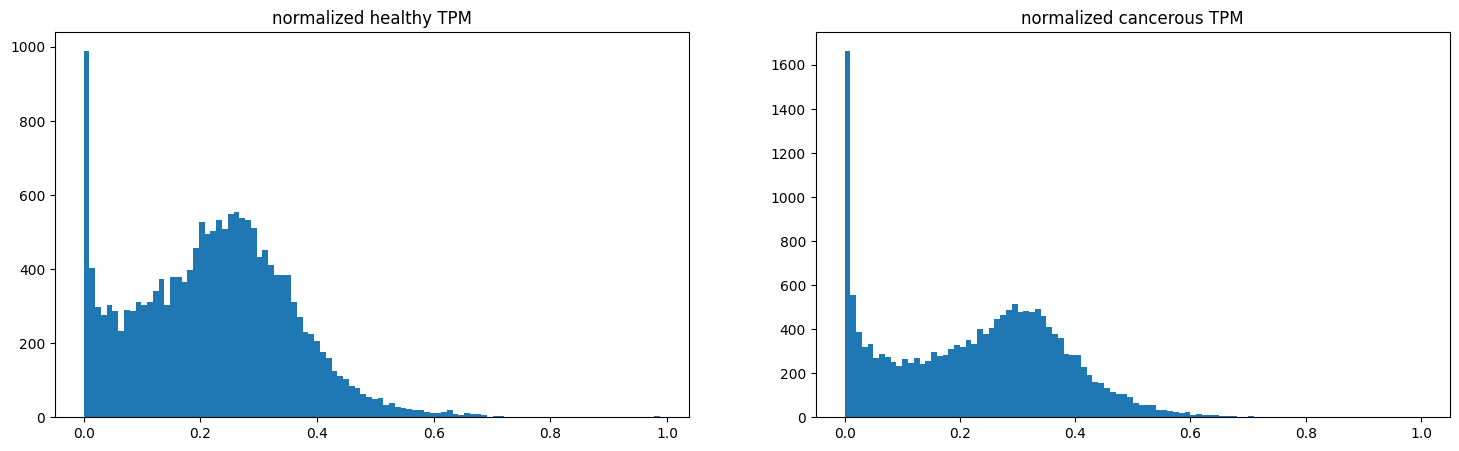

In [20]:
# norm healthy tpm
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.hist(df_nodes_genes['norm healthy tpm'], bins=100)
plt.title('normalized healthy TPM')

# norm cmp tpm
plt.subplot(1, 2, 2)
plt.hist(df_nodes_genes['norm cancerous tpm'], bins=100)
plt.title('normalized cancerous TPM')

plt.savefig('../tex/figures/03_02_normalized_tpm.png')
plt.show()

In [22]:
df_nodes_genes.drop(columns=['healthy tpm', 'cancerous tpm'], inplace=True)
df_nodes_genes

,name,id,norm healthy tpm,norm cancerous tpm,delta tpm,delta type
0,A1BG,ENSG00000121410,0.220900,0.056729,-0.164171,decrease
2,A1CF,ENSG00000148584,0.057012,0.080626,0.023614,increase
3,A2M,ENSG00000175899,0.579917,0.092398,-0.487519,decrease
5,A2ML1,ENSG00000166535,0.332704,0.062953,-0.269751,decrease
8,A3GALT2,ENSG00000184389,0.021656,0.046758,0.025101,increase
...,...,...,...,...,...,...
32858,ZXDC,ENSG00000070476,0.270354,0.289125,0.018771,increase
32859,ZYG11A,ENSG00000203995,0.039046,0.219098,0.180052,increase
32861,ZYG11B,ENSG00000162378,0.252818,0.291435,0.038617,increase
32863,ZZEF1,ENSG00000074755,0.280583,0.275600,-0.004983,decrease


## Calculate `delta tpm`

value of the difference between the normalized cancerous tpm and normalized healthy tpm

In [23]:
df_nodes_genes['delta tpm'] = df_nodes_genes['norm cancerous tpm'] - df_nodes_genes['norm healthy tpm']
df_nodes_genes['delta type'] = np.where(df_nodes_genes['delta tpm'] > 0, 'increase', 'decrease')

df_nodes_genes

,name,id,norm healthy tpm,norm cancerous tpm,delta tpm,delta type
0,A1BG,ENSG00000121410,0.220900,0.056729,-0.164171,decrease
2,A1CF,ENSG00000148584,0.057012,0.080626,0.023614,increase
3,A2M,ENSG00000175899,0.579917,0.092398,-0.487519,decrease
5,A2ML1,ENSG00000166535,0.332704,0.062953,-0.269751,decrease
8,A3GALT2,ENSG00000184389,0.021656,0.046758,0.025101,increase
...,...,...,...,...,...,...
32858,ZXDC,ENSG00000070476,0.270354,0.289125,0.018771,increase
32859,ZYG11A,ENSG00000203995,0.039046,0.219098,0.180052,increase
32861,ZYG11B,ENSG00000162378,0.252818,0.291435,0.038617,increase
32863,ZZEF1,ENSG00000074755,0.280583,0.275600,-0.004983,decrease


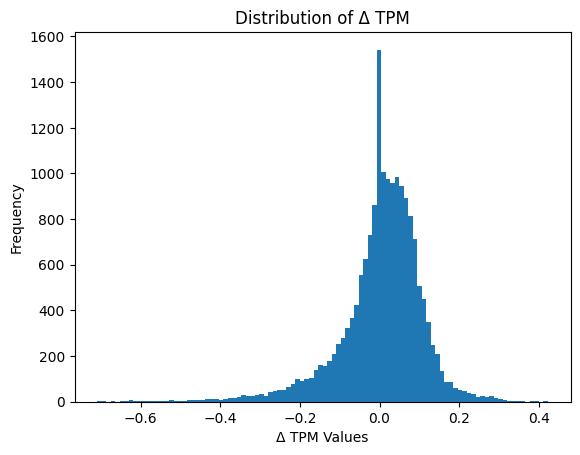

In [26]:
plt.hist(df_nodes_genes['delta tpm'], bins=100)
plt.title('Distribution of Δ TPM')
plt.xlabel('Δ TPM Values')
plt.ylabel('Frequency')

plt.savefig('../tex/figures/03_02_delta_tpm.png')
plt.show()

## Calculate `delta_tpm_relevant` with z score
Add a column that indicates if the change in the gene activity is relevant between cancer and healthy tissue.


Z Score of the delta TPM values is calculated and used to determine if the gene is relevant for cancer.
This z score means how many standard deviations the delta tpm value is away from the mean.


In [27]:
df_nodes_genes['z score'] = zscore(df_nodes_genes['delta tpm'])

# 1.96 for the highest 5% and the lowest 5% of the normal distribution
z_threshold = 1.96
df_nodes_genes['delta tpm relevant'] = df_nodes_genes['z score'].abs() > z_threshold

df_nodes_genes

,name,id,norm healthy tpm,norm cancerous tpm,delta tpm,delta type,z score,delta tpm relevant
0,A1BG,ENSG00000121410,0.220900,0.056729,-0.164171,decrease,-1.613031,False
2,A1CF,ENSG00000148584,0.057012,0.080626,0.023614,increase,0.183172,False
3,A2M,ENSG00000175899,0.579917,0.092398,-0.487519,decrease,-4.705922,True
5,A2ML1,ENSG00000166535,0.332704,0.062953,-0.269751,decrease,-2.622919,True
8,A3GALT2,ENSG00000184389,0.021656,0.046758,0.025101,increase,0.197398,False
...,...,...,...,...,...,...,...,...
32858,ZXDC,ENSG00000070476,0.270354,0.289125,0.018771,increase,0.136848,False
32859,ZYG11A,ENSG00000203995,0.039046,0.219098,0.180052,increase,1.679534,False
32861,ZYG11B,ENSG00000162378,0.252818,0.291435,0.038617,increase,0.326676,False
32863,ZZEF1,ENSG00000074755,0.280583,0.275600,-0.004983,decrease,-0.090362,False


## Save

In [28]:
df_nodes_genes.to_csv('../processed_data/nodes_genes.csv', index=False)

In [29]:
print(f"There are {df_nodes_genes.shape[0]} rows as gene nodes.")

There are 17626 rows as gene nodes.


In [35]:
import dataframe_image as dfi
df_nodes_genes_plot = df_nodes_genes.copy()
df_nodes_genes_plot = df_nodes_genes_plot.reset_index(drop=True)
df_nodes_genes_plot = df_nodes_genes_plot.rename(columns={'id': 'Gene ID', 
                                                         'name': 'Gene Name', 
                                                         'norm healthy tpm': 'norm. Healthy TPM', 
                                                         'norm cancerous tpm': 'norm. Cancerous TPM', 
                                                         'delta tpm': 'Δ TPM', 
                                                         'delta type': 'Δ Type', 
                                                         'delta tpm relevant': 'Δ TPM Relevant'})

dfi.export(df_nodes_genes_plot.head(5), '../tex/figures/03_02_gene_nodes.png')